<a href="https://colab.research.google.com/github/ShinyQ/Analisis-Sentimen-Kebijakan-Vaksinasi-COVID-19-Pemerintah_Naive-Bayes-Classifier/blob/main/Tugas_Besar_WGTIK_Simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library Yang Dibutuhkan**

In [ ]:
!pip install tweet-preprocessor
!pip install google_trans_new
!pip install tweepy
!pip install textblob
!pip install wordcloud
!pip install nltk

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from datetime import timedelta, datetime
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt 
from tweepy import OAuthHandler
from textblob import TextBlob
import preprocessor as p
import seaborn as sns
import pandas as pd
import numpy as np
import tweepy
import csv
import nltk
nltk.download('punkt')

# **Pengambilan Data (Crawling Data)**

In [3]:
access_token = "1339862432500498433-bWl7UFBHqQTdKCIbj0GavDCIsnHHeT"
access_token_secret ="vmP6Eb1WBGIwaGiRUHCLo69OwEzKVbcQOp6iMXBuw99aF"
consumer_key ="PodLGfK2ky8VbG1mFpEKOFLTQ"
consumer_secret="0QocN2CdV41mCdUEd5VWxpMjNB4UqCFE0hG6zPwmVOTEuCcf7f"

In [5]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

def scraptweets(search_words, date_since, date_until):

    db_tweets = pd.DataFrame(columns=['username', 'tweetcreatedts', 'text'])

    tweets = tweepy.Cursor(
                    api.search, q=search_words, lang="id", 
                    since=date_since, until=date_until,  tweet_mode='extended').items(1000)

    tweet_list = [tweet for tweet in tweets]

    for tweet in tweet_list:
        username = tweet.user.screen_name
        tweetcreatedts = tweet.created_at

        try:
            text = tweet.retweeted_status.full_text
        except AttributeError:
            text = tweet.full_text

        ith_tweet = [username, tweetcreatedts, text]

        db_tweets.loc[len(db_tweets)] = ith_tweet
    
    print('Proses Scrapping Selesai Dengan Jumlah Data', len(db_tweets))
    filename = 'covid_vaccine_tweets.csv'
    db_tweets.to_csv(filename, index=False)

today = datetime.today().strftime("%Y-%m-%d")
last_week = datetime.today() - timedelta(7)
last_week = last_week.strftime("%Y-%m-%d")

search_words = "#vaksin OR #vaksincovid19 OR #vaksincovid OR #VaksinUntukKita OR #vaksingratis OR vaksin OR vaksin gratis"
date_since = last_week
date_until = today

scraptweets(search_words, date_since, date_until)

Proses Scrapping Selesai Dengan Jumlah Data 1000


In [6]:
data = pd.read_csv('/content/covid_vaccine_tweets.csv')

In [7]:
data.sample(n=5)

,username,tweetcreatedts,text
78,PejuangPutera,2020-12-25 12:15:00,Setelah berbulan-bulan berjuang melawan pandem...
197,katzenjammer89,2020-12-25 06:33:30,"..Kebalikannya, Vaksin isunya akan gratis, dik..."
892,InfoCOVID19_id,2020-12-23 13:13:38,#HoaxBuster\n[SALAH] “Syarat Vaksin Gratis Jok...
312,prigeldigital,2020-12-25 01:48:31,Pemerintah Optimistis Pemulihan Ekonomi di 202...
188,urehheru,2020-12-25 06:52:49,Vaksin gratis. Petugas vaksinasi dibayar negar...


# **Pembersihan Data (Wrangle Data)**

In [8]:
data.isnull().sum()

username          0
tweetcreatedts    0
text              0
dtype: int64

In [9]:
def preprocessing_data(x):
    return p.clean(x)

def tokenize_data(x):
    return p.tokenize(x)

data['tweet_clean'] = data['text'].apply(preprocessing_data)
data['tweet_clean'] = data['tweet_clean'].apply(tokenize_data)
data = data.drop_duplicates()

In [10]:
from google_trans_new import google_translator  
translator = google_translator()  

def convert_eng(tweet):
    return translator.translate(tweet,lang_tgt='en') 

data['tweet_english'] = data['tweet_clean'].apply(convert_eng)

In [11]:
ps = PorterStemmer() 

def stemming_data(x):
    return ps.stem(x)

data['tweet_english'] = data['tweet_english'].apply(stemming_data)

In [12]:
data_tweet = list(data['tweet_english'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

def klasifikasi(polaritas):
    if polaritas > 0.0:
        return 'Positif'
    elif polaritas > 0.0 == 0.0:
        return 'Netral'
    else:
        return 'Negatif'

for i, tweet in enumerate(data_tweet):
    analysis = TextBlob(tweet)
    polaritas += analysis.polarity

    if analysis.sentiment.polarity > 0.0:
        total_positif += 1
        status.append('Positif')
    elif analysis.sentiment.polarity == 0.0:
        total_netral += 1
        status.append('Netral')
    else:
        total_negatif += 1
        status.append('Negatif')

    total += 1 

status = pd.DataFrame({'klasifikasi': status})
data['klasifikasi'] = status
data.tail()

print(f'Hasil Analisis Data:\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}')
print(f'\nTotal Data : {total}')

Hasil Analisis Data:
Positif = 897
Netral = 66
Negatif = 37

Total Data : 1000


In [13]:
dataset = data.drop(['username',	'tweetcreatedts',	'text', 'tweet_clean'], axis=1, inplace=False)
dataset = [tuple(x) for x in dataset.to_records(index=False)]

import random

set_positif = []
set_negatif = [] 
set_netral = []

for n in dataset:
    if(n[1] == 'Positif'):
      set_positif.append(n)
    elif(n[1] == 'Negatif'):
      set_negatif.append(n)
    else: 
      set_netral.append(n)

set_positif = random.sample(set_positif, k=int(len(set_positif)/2))
set_negatif = random.sample(set_negatif, k=int(len(set_negatif)/2))
set_netral = random.sample(set_netral, k=int(len(set_netral)/2))

train = set_positif + set_negatif + set_netral

train_set = []

for n in train:
     train_set.append(n)

In [14]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train_set)
print('Akurasi Test:', cl.accuracy(dataset))

Akurasi Test: 0.975


In [15]:
data_tweet = list(data['tweet_english'])
polaritas = 0

status = []
total_positif = total_negatif = total_netral = total = 0

for i, tweet in enumerate(data_tweet):
    analysis = TextBlob(tweet, classifier=cl)

    if analysis.classify() == 'Positif':
        total_positif += 1
    elif analysis.classify() == 'Netral':
        total_netral += 1
    else:
        total_negatif += 1
    
    status.append(analysis.classify())
    total += 1 

status = pd.DataFrame({'klasifikasi_bayes': status})
data['klasifikasi_bayes'] = status

print(f'\nHasil Analisis Data:\nPositif = {total_positif}\nNetral = {total_netral}\nNegatif = {total_negatif}')
print(f'\nTotal Data : {total}')


Hasil Analisis Data:
Positif = 912
Netral = 62
Negatif = 26

Total Data : 1000


# **Visualisasi Data**

In [16]:
def show_pie(label, data, legend_title) :
    fig, ax = plt.subplots(figsize=(8, 10), subplot_kw=dict(aspect='equal'))

    labels = [x.split()[-1] for x in label]

    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}% ({:d})".format(pct, absolute)

    wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), 
                                      textprops=dict(color="w"))

    ax.legend(wedges, labels,
              title= legend_title,
              loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=10, weight="bold")
    plt.show()

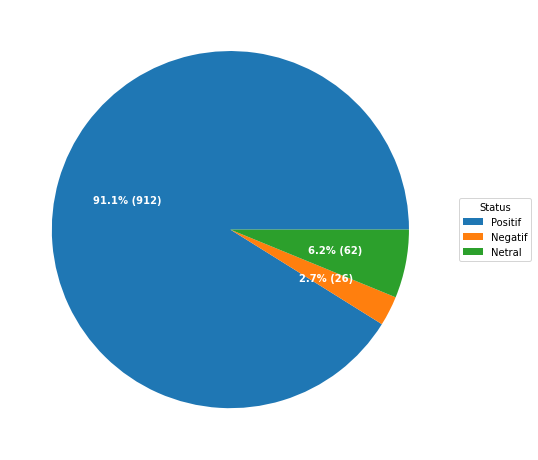

In [17]:
label = ['Positif', 'Negatif', 'Netral']
count_data = [total_positif+1, total_negatif+1, total_netral]

show_pie(label, count_data, "Status")

In [18]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud) 
    plt.axis("off");

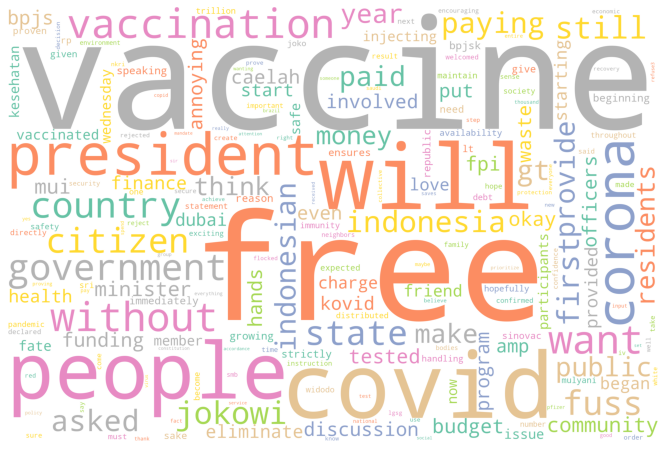

In [19]:
all_words = ' '.join([tweets for tweets in data['tweet_english']])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=3, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(all_words)
plot_cloud(wordcloud)

## **Data Klasifikasi Yang Diubah Setelah Menggunakan Metode Naive Bayes Classifier**

In [20]:
data_eval = [tuple(x) for x in data.to_records(index=False)]

for n in data_eval:
    if n[5] != n[6]:
       print(f'Text: {n[3]}\nClassifier: {n[5]}\nClassifier Bayes: {n[6]} \n')

Text: Tolak Vaksin Palu Arit Gratis !Tidak habis pikir sama Pan Indonesia dan Lee Po Cs yang tak lelah berbisnis kala Pandemi,Demi setor terus ke ChinaBanyak cara untuk sembuh Virus MahkotaGratis untuk Vaksin Merah Putih oke, tapi baru bung !
Classifier: Positif
Classifier Bayes: Negatif 

Text: Setelah berbulan-bulan berjuang melawan pandemi, lelah rasanya, bnyk kerugian yg udah kita alamin. Akhirnya bisa nafas lega juga. Vaksin sudah ada &amp; gratis.Thnk God Thnk
Classifier: Negatif
Classifier Bayes: Positif 

Text: Semoga dana ini tidak dikorupsi ya
Classifier: Netral
Classifier Bayes: Positif 

Text: Semoga dana ini tidak dikorupsi ya
Classifier: Netral
Classifier Bayes: Positif 

Text: Kasihan rakyat Indonesia, sampai harus berterima kasih &amp; apresiasi kepada Presiden atas apa yang seharusnya menjadi HAK rakyat Indonesia ; yaitu vaksin gratis.Suasana bernegara ini sangat menyedihkan.
Classifier: Negatif
Classifier Bayes: Positif 

Text: Efikasi vaksin sinovac asal china belum 